Author:  <b> Rhondene Wint </b>   
Instructor: <b> Dr. Huerta-Sanchez</b>  
Due Date:  March 21 


**From README file **

- Column 1: chromosome number [1-22]
- Column 2: start physical position of tract, base-0 (bp)
- Column 3: end physical position of tract, base-1 (bp)
- Column 4: haploid ancestry call of tract 
- Column 5: start genetic position of on tract (cM)
- Column 6: end genetic position of on tract (cM)

In [2]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn
import os

In [1]:
def ancestry_level(paths,chrom,ANC,adm):
    """
    Task: Merges the haploid bed files for each individual and compute the level of ancestry on chromosome 21 
    
    args:
    paths: list of all the paths of each admixed group bed files 
    chrom (string):  chromosome numbe
    adm(list ) :  'ACB', 'ASW','MXL', or 'CLM'...
    ANC (list):  list of the three Ancestrys AFR, EUR, NAT
    
    Output: A nested dictionarY with the AFR, EUR, NAT ancestry level of each individual from each admixed group
      #nested dict:  'AFR: {ACB':{ind: ratio}},   { PUR: {ind: ratio}}.....) 
    """
    chrom = chrom
    all_anc = dict()
    for A in ANC:
        all_anc[A] = dict()
        """Compute the level of A of individuals from all admixed groups """
        for path in paths:   
            os.chdir(path)
            id_list = os.popen("ls *.bed").read().split('\n') #reads in all the bed file paths
            del id_list[-1]                                   #last element is always an empty quotation mark, dunno why tho
            admixed = next(filter(lambda x: x in path,adm))  #returns the admixed group name dictionary,do I need this tho?
            anc_dict = dict() 
            """ Each iteration will read in both haploid bed files- A and B for each individual and merge them into one table"""
            for i in range(len(id_list)):                     #each individual in bed file 
                df1= pd.read_table(id_list[i], header=None)
                df2 =pd.read_table(id_list[(i+1)], header=None)
                df = pd.concat([df1,df2])
                cols = ['Chrom_Num', 'Start_phys','End_phys','Ancestry','Start_gen','End_gen']
                df.columns=cols
                """Compute Ancestry ratio"""
                anc = df[(df.Chrom_Num==chrom) & (df.Ancestry==A) ].End_phys.sum() - df[(df.Chrom_Num==chrom) & (df.Ancestry==A) ].Start_phys.sum()
                Total_anc = (df[df.Chrom_Num ==chrom].End_phys.sum()) - (df[df.Chrom_Num ==chrom].Start_phys.sum())
                if anc!=0:
                    anc_ratio = anc/Total_anc
                else:
                    anc_ratio = anc
                """Update dictionary with indviduals and corresponding ancestry  level"""       
                ind = id_list[i][:7]   
                anc_dict[ind] = anc_ratio
                i+=2
                if i > (len(id_list)-1):
                    break
                    
            assert(len(anc_dict))== (len(id_list)/2)
            
            all_anc[A][admixed]= anc_dict                   
        
            
    return all_anc    

In [3]:
paths = ['C:/Users/My LENOVO/Desktop/Spring2018/biostats/1000genomes/ancestry/ACB/PopPhased/bed_files',
        'C:/Users/My LENOVO/Desktop/Spring2018/biostats/1000genomes/ancestry/ASW/ASW/PopPhased/bed_files/ASW/PopPhased',
         'C:/Users/My LENOVO/Desktop/Spring2018/biostats/1000genomes/ancestry/CLM/CLM/PopPhased/bed_files/CLM/PopPhased',
         'C:/Users/My LENOVO/Desktop/Spring2018/biostats/1000genomes/ancestry/MXL/PopPhased/bed_files/MXL/PopPhased',
         'C:/Users/My LENOVO/Desktop/Spring2018/biostats/1000genomes/ancestry/PEL/PopPhased/bed_files/PEL/PopPhased',
         'C:/Users/My LENOVO/Desktop/Spring2018/biostats/1000genomes/ancestry/PUR/PopPhased/bed_files/PUR/PopPhased'
        ]

ANC = ['AFR', 'EUR', 'NAT']
adm = ['ACB', 'ASW','PEL', 'MXL', 'CLM', 'PUR']

In [4]:
ANCS = ancestry_level(paths,'21',ANC,adm)


In [5]:
print(len(ANCS))  # outermost dictionary is 3, one for each ancestry AFR, EUR, NAT
print (len(ANCS['AFR'])) # Stores 6 innerdictionaries, each of which is keyed by the admixed group name ACB, ASW, CLM,MXL, PEL, PUR
print( len(ANCS['AFR']['PEL']))  # Stores level of ancestry for each individual

3
6
86


## Map the Admixed Individual to their Total Variants

In [6]:
os.chdir('C:/Users/My LENOVO/Desktop/Spring2018/biostats/1000genomes')
variants= pd.read_csv('var_sites2.csv', header=0, delimiter =',')

In [7]:
def build_ancestry_table(anc_dict,ancestry, variants_df):
    """ Maps each individual from the admixed group to their total variants number in variant_df from HW1 """
    
    frames =[]
    for key in anc_dict[ancestry].keys():
        df= pd.DataFrame(list(anc_dict[ancestry][key].items()), columns=['Individual', ancestry+'_anc'])
        var = variants_df[variants_df['Population']==key]
        var.sort_values(var.columns[0], inplace=True)
        df.sort_values(df.columns[0], inplace=True)
        if len(df) != len(var):  #choose only values in var, drop the missing the values 
            missing = list((filter(lambda x: x not in var.Individual.values,df.Individual.values)))
            for m in missing:
                df = df[df.Individual != m] 
        df['Total_Variants'] = var['Var_Sites'].values
        df['Population'] = key; 
        frames.append(df)
        
    result = pd.concat(frames)
    return result 

In [8]:
AFR_df = build_ancestry_table(ANCS,'AFR', variants)  #ignore warning, it is doing what I intended
EUR_df = build_ancestry_table(ANCS,'EUR', variants)
NAT_df = build_ancestry_table(ANCS,'NAT', variants)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [9]:
AFR_df.head(5)

,Individual,AFR_anc,Total_Variants,Population
0,HG01879,0.214094,29655,ACB
1,HG01880,0.919102,28752,ACB
2,HG01882,0.827327,30298,ACB
3,HG01883,0.688713,28437,ACB
4,HG01885,0.840776,30172,ACB


## Plot Ancestry_Level vs Total Variants


In [10]:
plt.style.use('seaborn-deep')
from IPython.core.pylabtools import figsize
figsize(14, 7)

In [11]:
def graph_ancestry(df, ancestry, font):
    xmin, xmax = df[df.columns[1]].min(), 1.0            #Ancestry column 
    ymin, ymax = df[df.columns[2]].min(), df[df.columns[2]].max()   #Variant_sites column 
    
    fig = plt.figure(figsize = (8,8))
    colour = df.columns[3]
    seaborn.pairplot( x_vars= df.columns[1],y_vars= df.columns[2], data=df, hue=colour, size=8,
                    plot_kws=dict(alpha=0.8))
    plt.title( ' Level of {} Ancestry for The Six Admixed Groups (1000Genomes)'.format(ancestry), fontdict=font)
    plt.xlim( xmin, xmax )
    plt.ylim( ymin, ymax )
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlabel("Level of {} Ancestry ".format(ancestry), fontsize=15)
    plt.ylabel("Total Variant Sites Per Genome", fontsize=15)
    
    return fig

<h1>             African Ancestry </h1>

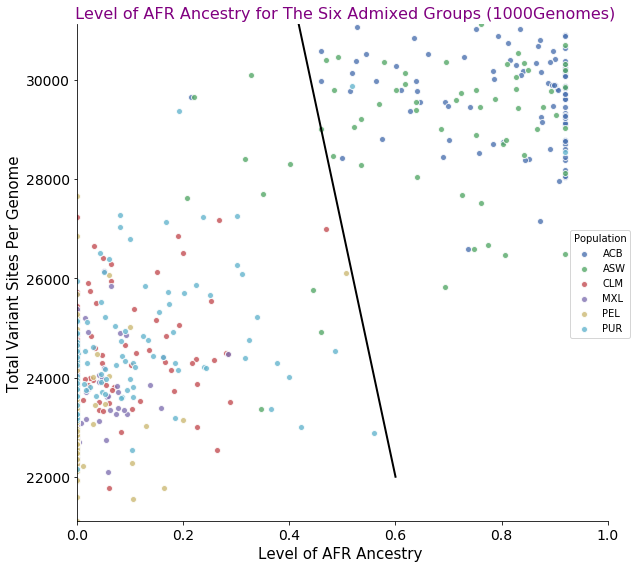

In [12]:
font = {'family': 'sans serif', 'color':  'purple', 'weight': 'normal', 'size': 16}
graph_ancestry(AFR_df, 'AFR', font)
plt.plot([0.6, 0.4], [22000, 32000], 'k-', lw=2)
plt.tight_layout()
plt.show()

<h2> Analysis of African Ancestry  </h2>

- Not surprisingly, ACB and ASW, two mostly black population have the highest variants per genome, and the most African ancestry 
- PUR (Puerto Rico) and CLM (Colombia) individuals show a fair amount of African Ancestry. This is expected give the history of African slavery in both countries. It is noteworthy that Colombia (CLM) has the 2nd largest black population in the Western Hemisphere.  https://en.wikipedia.org/wiki/Afro-Latin_Americans
- It is apparent PEL has the least African ancestry as it clusters on the y axis
- In general, as the Number of Variant site increases, the likelihood individual having of African ancestry

In [13]:
for ad in adm:
    print ('Mean and Modal AFR in ', ad,': ', AFR_df[AFR_df['Population']== ad]['AFR_anc'].mean(),
           AFR_df[AFR_df['Population']== ad]['AFR_anc'].mode() )

Mean and Modal AFR in  ACB :  0.8077001623853892 0    0.919102
dtype: float64
Mean and Modal AFR in  ASW :  0.6776401317929435 0    0.919102
dtype: float64
Mean and Modal AFR in  PEL :  0.019062993709063846 0    0.0
dtype: float64
Mean and Modal AFR in  MXL :  0.03320030026000651 0    0.0
dtype: float64
Mean and Modal AFR in  CLM :  0.07130232790599593 0    0.0
dtype: float64
Mean and Modal AFR in  PUR :  0.11520027514876849 0    0.0
dtype: float64


# Native American Ancestry 

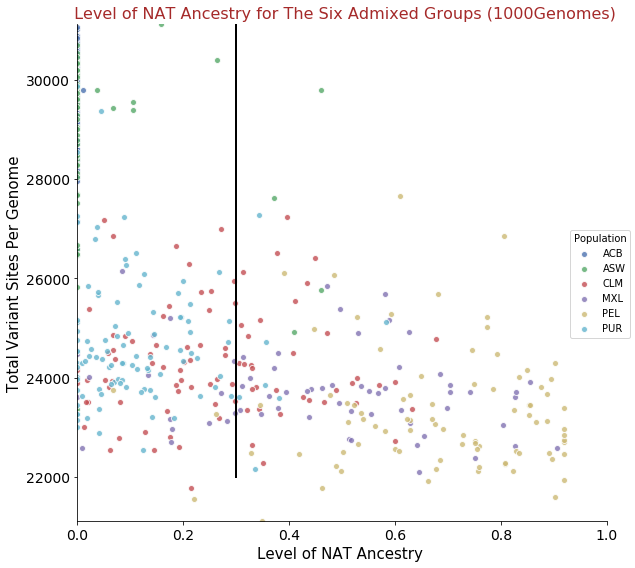

In [14]:
font = {'family': 'sans serif', 'color':  'brown', 'weight': 'normal', 'size': 16}
graph_ancestry(NAT_df, 'NAT', font)
plt.plot([0.3, 0.3], [22000, 32000], 'k-', lw=2)
plt.tight_layout()
plt.show()

## Analysis of Native American Ancestry     


- ACB and ASW indvidual show the least admixture with Native American. 
- As expected, PEL (Peruvians) and MXL (Mexicans) have the highest Native American Ancestry. For these two populations, the level of NAT ancestry negatively correlates with the number of variants sites. 


In [15]:
for ad in adm:
    print ('Mean and Modal NAT are: ',  ad,' ', NAT_df[NAT_df['Population']== ad]['NAT_anc'].mean(), ' ',
           NAT_df[NAT_df['Population']== ad]['NAT_anc'].mode() )

Mean and Modal NAT are:  ACB   0.00011580274717592184   0    0.0
dtype: float64
Mean and Modal NAT are:  ASW   0.039963978961743835   0    0.0
dtype: float64
Mean and Modal NAT are:  PEL   0.6793477211638952   0    0.919102
dtype: float64
Mean and Modal NAT are:  MXL   0.4607097253713034   0    0.0
dtype: float64
Mean and Modal NAT are:  CLM   0.25306929404370787   0    0.0
dtype: float64
Mean and Modal NAT are:  PUR   0.11160689500888782   0    0.0
dtype: float64


# European Ancestry

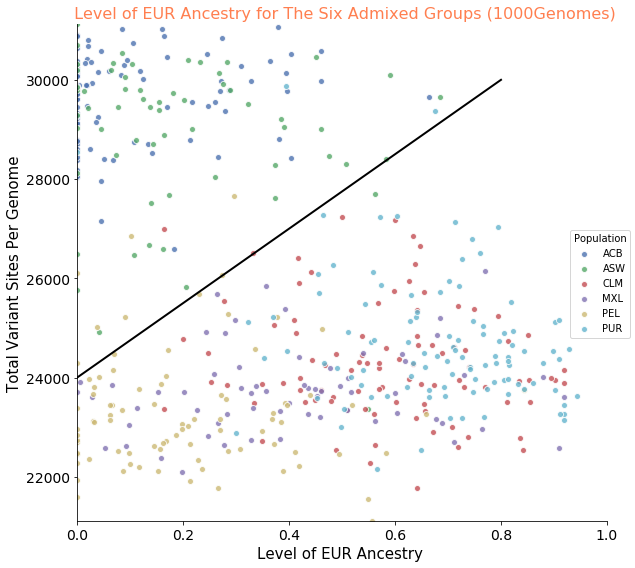

In [16]:
font = {'family': 'sans serif', 'color':  'coral', 'weight': 'normal', 'size': 16}

graph_ancestry(EUR_df, 'EUR', font)
plt.plot([0.0, 0.8], [24000, 30000], 'k-', lw=2)
plt.tight_layout()
plt.show()

## Analysis of European Ancestry 


- *** I used median instead of mode for European because I was getting a long list of values that took up too much space***
- PUR and CLM individuals have the highest level of European ancestry, which tends to increase as number of variant site decreases. 
- ACB and ASW has the least amount of EUR ancestry, but in fair ammounts. 


In [17]:
for ad in adm:
    print ('Mean and median EUR are: ',  ad,' ', EUR_df[EUR_df['Population']== ad]['EUR_anc'].mean(), ' ' 
             , EUR_df[EUR_df['Population']== ad]['EUR_anc'].median() )     

Mean and median EUR are:  ACB   0.10766525124700049   0.027184326073211
Mean and median EUR are:  ASW   0.19551045429576225   0.14313580367909537
Mean and median EUR are:  PEL   0.20632757934712406   0.16799691895803634
Mean and median EUR are:  MXL   0.4064260076271605   0.38747540716678047
Mean and median EUR are:  CLM   0.5808474946256947   0.5903895590953876
Mean and median EUR are:  PUR   0.6798371098815519   0.7060189480025726


# Q6.  An Intresting Analysis

1.  What are the Various Admixed groups Likely to be Mixed with? For example what is a Caribbean Person Likely Mixed with """
2.  The correlation between European and Native American ancestry vs European and African Ancestry 

In [18]:
## sort and merge all three tables and and print graphs for each admixed group
AFR_df.sort_values(AFR_df.columns[0], inplace=True)
NAT_df.sort_values(NAT_df.columns[0], inplace=True)
EUR_df.sort_values(EUR_df.columns[0], inplace=True)

combined= AFR_df
combined['NAT_anc'] = NAT_df['NAT_anc']
combined['EUR_anc'] = EUR_df['EUR_anc']

In [19]:
combined.head(5)

,Individual,AFR_anc,Total_Variants,Population,NAT_anc,EUR_anc
0,HG00551,0.000000,23631,PUR,0.008399,0.942602
1,HG00553,0.168076,27131,PUR,0.000000,0.712368
2,HG00554,0.375734,24298,PUR,0.087275,0.465805
3,HG00637,0.133795,24750,PUR,0.051562,0.718538
4,HG00638,0.051853,25216,PUR,0.195483,0.639552


In [20]:
""" re-order the columns so my life becomes an iota easier """
_ = combined['Total_Variants']
combined.drop(labels=['Total_Variants'], axis=1,inplace = True)
combined.insert(1, 'Total_Variants', _)
combined.head(5)

,Individual,Total_Variants,AFR_anc,Population,NAT_anc,EUR_anc
0,HG00551,23631,0.000000,PUR,0.008399,0.942602
1,HG00553,27131,0.168076,PUR,0.000000,0.712368
2,HG00554,24298,0.375734,PUR,0.087275,0.465805
3,HG00637,24750,0.133795,PUR,0.051562,0.718538
4,HG00638,25216,0.051853,PUR,0.195483,0.639552


In [24]:
from pandas.plotting import parallel_coordinates

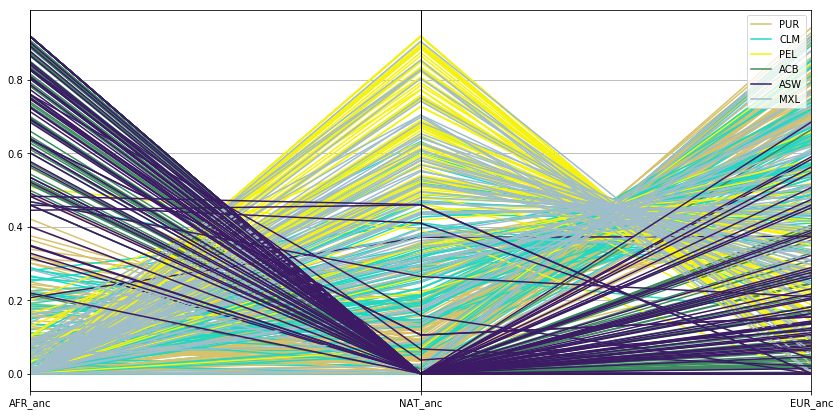

In [25]:
""" Parallel Coordinates is a plotting tool for visualiing multivariate data. Each vertical line represents one attribute. 
One set of connected line segments represents one data point. Points that tend to cluster will appear closer together.
I will use parallel coordinates to summarize how the 3 ancestries are related  in each population.
"""
plt.figure()
parallel_coordinates(combined.iloc[:, 2:] , 'Population');  
plt.show()

#  Comments

- From the Parallel coordinates graph, we see where individuals from ACB and ASW populations are mostly admixed with African and European.
-  CLM have the most admixed individuals. That is, although  they are mainly of European descent they have fair amounts of both African and Native American Ancestry
-  PUR are  the least admixed, and  admixing is more common with Native American/ European, than Native American/ African  
